In [1]:
#import corner
#stats imports
#plt version 3.3.4
import matplotlib.pyplot as plt
#sns version 0.11.1
import seaborn as sns
#scipy version 1.7.2
import scipy.stats as stats
#statsmodels.api version 0.13.2
import statsmodels.api as sm
from statsmodels.formula.api import ols
#from statsmodels.stats.multitest import multipletest
import  statsmodels.sandbox.stats.multicomp as multi
#easier stats to use with pandas
#pg version 0.5.1
import pingouin as pg



#other imports
#plt version 3.3.4
import pandas as pd
#np.version 1.20.1
import numpy as np

import os

cwd = os.getcwd()

C:\Users\F004b3k\AppData\Local\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#read in SGN counts for stats
stat_df = pd.read_csv('injection_groups_all_columns_added.csv')

# SGN_contra-->DTN comparisons (ANOVA) by group (DTN_hit, DTN_adjacent)

In [3]:
#stats from ahv_analysis
#this box is only for DTN_group comparison
#Maybe anova is most approporiate if we're also comparing brain areas (SGN_ipsi vs SGN_contra instead of trying to compare to_LMN and to_DTN in the same comparison )
#Using pg.ANOVA (2 way) for each variable
#using Tukey for posthoc
df = stat_df

#filter out DTN_miss (not enough samples)
df = df.loc[(~(df['DTN_group']=='DTN_miss'))&(~(df['DTN_group'].isnull()==True))]

#get only the SGN_contra_avg_counts for DTN
#columns we will need....don't add double_label unless we do a double_label comparison
#SGN_contra_to_DTN_columns = ['Brain','LMN_group','DTN_group','SGN_contra_to_DTN_avg_count','SGN_contra_to_LMN_avg_count','SGN_contra_Double_label_avg_count']
SGN_to_DTN_columns = ['Brain','DTN_group','SGN_contra_to_DTN_avg_count','SGN_ipsi_to_DTN_avg_count']

#SGN_contra_to_LMN_columns = ['Brain','LMN_group','SGN_contra_to_DTN_avg_count','SGN_contra_to_LMN_avg_count','SGN_contra_Double_label_avg_count']
#reason for df filter 

df = df[SGN_to_DTN_columns]

comparison_ops = ['SGN_contra_to_DTN_avg_count','SGN_ipsi_to_DTN_avg_count']
#pg ANOVA assumptions:
#equal variance

#create a table that stores the comparison, path, homoscedacicity values, normality values

group_list = []
homoscedastic_path_list = []
homoscedastic_list = []
normality_list = []
normality_path_list = []
dv_list = []

#performs an anova and saves the results

#data filters and reasoning if neccessary


#saving location and strings
if os.path.exists(os.path.join(cwd,'to_DTN_avg_count_stats')) == False:
    stat_folder = os.mkdir('to_DTN_avg_count_stats')
stat_folder = os.path.abspath(os.path.join(cwd,'to_DTN_avg_count_stats'))

#need to melt the dataframe so 'counts'is the only variable?
melted = pd.melt(df, id_vars=['Brain','DTN_group'], 
                 value_vars=comparison_ops,
                var_name='ipsi_contra',value_name='avg_count')



#filter such that we only have avg to_DTN numbers for DTN hit and miss and only avt to_LMN numbers for LMN hit and miss
#dependent variable (one for pg.anova)
#melted['group'] = np.where(melted['projection_area'].str.contains('DTN'),melted['DTN_group'],melted['LMN_group'])
#filter out NaNs and LMN_miss or DTN_miss as these are not included in the paper
#melted = melted.loc[(melted['group'].isnull()==False) & (melted['group'].str.contains('LMN_miss')==False) & (melted['group'].str.contains('DTN_miss')==False)]

df = melted
dv = 'avg_count'
#list of variables to compare
between = ['DTN_group','ipsi_contra']
base_savestring = '_'.join(between)
base_savestring = '_'.join([dv,base_savestring])
anova_savestring = 'ANOVA.csv'
#show and save anova table for 'between'
df.anova(dv=dv,between=between).to_csv(os.path.join(stat_folder,
                (base_savestring + anova_savestring)))

for group in between:

    #string for saving
    tukey_savestring = 'tukey.csv'
    #equal_variances
    homoscedasticity_savestring = 'homoscedasticity.csv'
    #normality
    normality_savestring = 'normality.csv' 
    #get and save normality/equal variance data for the comparisons
    homoscedasticity = pg.homoscedasticity(data=df,dv=dv,group=group)
    homoscedasticity.to_csv(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' +homoscedasticity_savestring)))
    normality = pg.normality(data=df,dv=dv,group=group)
    normality.to_csv(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' + normality_savestring)))
    #append normality and homoscedacity true/false and csv location to lists for val_df
    group_list.append(group)
    homoscedastic_path_list.append(os.path.abspath(os.path.join(stat_folder,(base_savestring +'group_' + group + '_' + homoscedasticity_savestring))))
    homoscedastic_list.append(homoscedasticity['equal_var'].values[0])
    normality_list.append(normality['normal'].values[0])
    normality_path_list.append(os.path.abspath(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' +normality_savestring))))
    dv_list.append(dv)
    #save tukey comparison table
    #between for tukey has to be single group
    tukey = df.pairwise_tukey(dv=dv,between=group)

    tukey.to_csv(os.path.join(stat_folder,'_'.join(['dv',dv,'group',group,tukey_savestring])))




#interpretation:
    #normality/homoscedasticity - 
        #DTN_group levene homoscedasticity  = False
        #DTN_group normality = False.....consider alternate test?
        #ipsi_contra is homoscedastic but not normal.  
        

#anovas/tukeys
    #There's a significant interaction between group(DTN_hit, DTN_adjacent) and brain region(SGN_ipsi, SGN_contra)
    #interaction plots are below.  looks like counts for SGN_contra to DTN are higher for DTN hits and lower for DTN_adjacent 
    #while DTN_hit and DTN_adjacent counts are the same for ipsi or contra SGN.  
                    #Source	SS      	DF	MS       	F       	     p-unc	np2
                #DTN_group	192.1754049	1	192.1754049	5.49006705	0.028572681	0.199710937
            #ipsi_contra	276.920184	1	276.920184	7.911055939	0.010139635	0.264486013
#DTN_group * ipsi_contra	317.4414544	1	317.4414544	9.068667607	0.006422246	0.291891101
                #Residual	770.0923993	22	35.00419997			


#plotting the interaction below


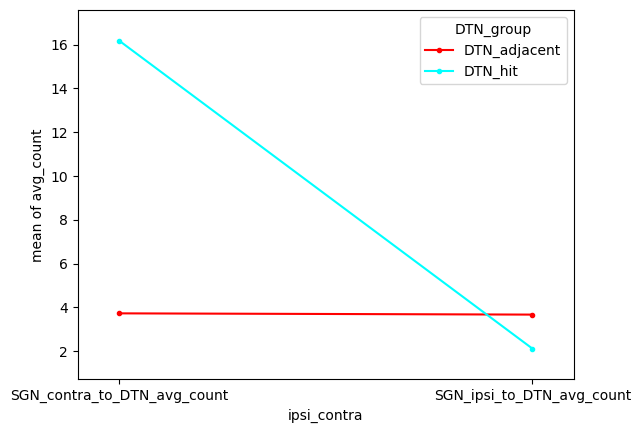

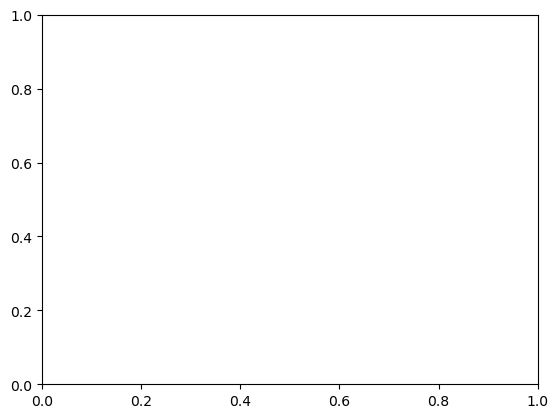

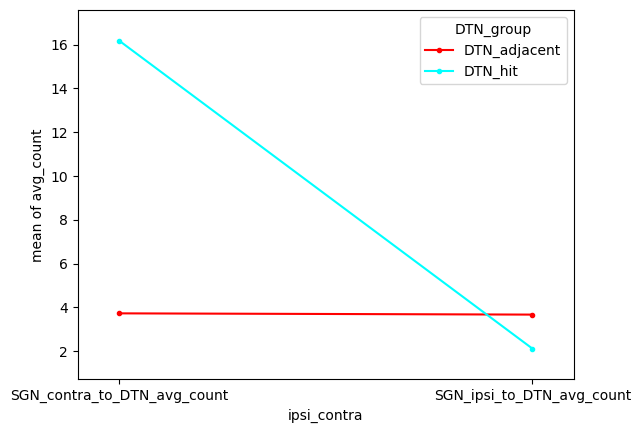

In [4]:
#There's a significant interaction between group(DTN_hit, DTN_adjacent, LMN_hit, LMN_adjacent) and projection area(to_LMN, to_DTN)
#We should just do a t-test ;-)
from statsmodels.graphics.factorplots import interaction_plot

df = melted

fig = plt.figure()
ax = fig.add_subplot(111)
interaction_plot(df['ipsi_contra'],df['DTN_group'],df['avg_count'])
#interaction_plot(df['symm_class'],df['brain area'],df['max_slope'],colors=[brain_area_c_dict['NPH'],brain_area_c_dict['PGRNd'],brain_area_c_dict['SGN']])

#plt.savefig('brain_area_by_symm_class_interaction_plot.png')




In [5]:
#still for SGN_to_DTN_avg_counts
#checking to see how normal/homoscedastic our comparisons are....

to_DTN_avg_val_df = pd.DataFrame({'group':group_list,'homoscedastic_path':homoscedastic_path_list,
                                 'homoscedastic':homoscedastic_list,'normality_path':normality_path_list,
                                 'normality':normality_list,'dv':dv_list})
to_DTN_avg_val_df[['dv','group','homoscedastic','normality']]
#to_DTN_avg_val_df.to_csv('to_DTN_avg_counts_normality_table.csv')

,dv,group,homoscedastic,normality
0,avg_count,DTN_group,False,False
1,avg_count,ipsi_contra,True,False


In [6]:
to_DTN_avg_val_df

,group,homoscedastic_path,homoscedastic,normality_path,normality,dv
0,DTN_group,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,False,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,False,avg_count
1,ipsi_contra,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,True,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,False,avg_count


# SGN_contra-->DTN comparisons (ANOVA) by group (DTN_hit, DTN_adjacent) without brains with anterograde transport (84, 91 and 89)

In [7]:
#this box is only for DTN_group comparison minus brains with notable anterograde transport
#same as original comparison, but with JG_84 and JG_91 removed since there was some anterograde transport
#Maybe anova is most approporiate if we're also comparing brain areas (SGN_ipsi vs SGN_contra instead of trying to compare to_LMN and to_DTN in the same comparison )
#Using pg.ANOVA (2 way) for each variable
#using Tukey for posthoc
df = stat_df

#filter out DTN_miss (not enough samples)
df = df.loc[(~(df['DTN_group']=='DTN_miss'))&(~(df['DTN_group'].isnull()==True))]
#filter out brains with anterograde transport (in case we can't tell if cells are retrogradely labeled or receive dense terminal innervation near soma)
df = df.loc[(df['Brain']!='JG_84')&(df['Brain']!='JG_91')&(df['Brain']!='JG_89')]
#get only the SGN_contra_avg_counts for DTN
#columns we will need....don't add double_label unless we do a double_label comparison
#SGN_contra_to_DTN_columns = ['Brain','LMN_group','DTN_group','SGN_contra_to_DTN_avg_count','SGN_contra_to_LMN_avg_count','SGN_contra_Double_label_avg_count']
SGN_to_DTN_columns = ['Brain','DTN_group','SGN_contra_to_DTN_avg_count','SGN_ipsi_to_DTN_avg_count']

#SGN_contra_to_LMN_columns = ['Brain','LMN_group','SGN_contra_to_DTN_avg_count','SGN_contra_to_LMN_avg_count','SGN_contra_Double_label_avg_count']
#reason for df filter 

df = df[SGN_to_DTN_columns]

comparison_ops = ['SGN_contra_to_DTN_avg_count','SGN_ipsi_to_DTN_avg_count']
#pg ANOVA assumptions:
#equal variance

#create a table that stores the comparison, path, homoscedacicity values, normality values

group_list = []
homoscedastic_path_list = []
homoscedastic_list = []
normality_list = []
normality_path_list = []
dv_list = []

#performs an anova and saves the results

#data filters and reasoning if neccessary


#saving location and strings
if os.path.exists(os.path.join(cwd,'to_DTN_avg_counts_without_anterograde_stats')) == False:
    stat_folder = os.mkdir('to_DTN_avg_counts_without_anterograde_stats')
stat_folder = os.path.abspath(os.path.join(cwd,'to_DTN_avg_counts_without_anterograde_stats'))

#need to melt the dataframe so 'counts'is the only variable?
melted = pd.melt(df, id_vars=['Brain','DTN_group'], 
                 value_vars=comparison_ops,
                var_name='ipsi_contra',value_name='avg_count')



#filter such that we only have avg to_DTN numbers for DTN hit and miss and only avt to_LMN numbers for LMN hit and miss
#dependent variable (one for pg.anova)
#melted['group'] = np.where(melted['projection_area'].str.contains('DTN'),melted['DTN_group'],melted['LMN_group'])
#filter out NaNs and LMN_miss or DTN_miss as these are not included in the paper
#melted = melted.loc[(melted['group'].isnull()==False) & (melted['group'].str.contains('LMN_miss')==False) & (melted['group'].str.contains('DTN_miss')==False)]

df = melted
dv = 'avg_count'
#list of variables to compare
between = ['DTN_group','ipsi_contra']
base_savestring = '_'.join(between)
base_savestring = '_'.join([dv,base_savestring])
anova_savestring = 'ANOVA.csv'
#show and save anova table for 'between'
df.anova(dv=dv,between=between).to_csv(os.path.join(stat_folder,
                (base_savestring + anova_savestring)))

for group in between:

    #string for saving
    tukey_savestring = 'tukey.csv'
    #equal_variances
    homoscedasticity_savestring = 'homoscedasticity.csv'
    #normality
    normality_savestring = 'normality.csv' 
    #get and save normality/equal variance data for the comparisons
    homoscedasticity = pg.homoscedasticity(data=df,dv=dv,group=group)
    homoscedasticity.to_csv(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' +homoscedasticity_savestring)))
    normality = pg.normality(data=df,dv=dv,group=group)
    normality.to_csv(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' + normality_savestring)))
    #append normality and homoscedacity true/false and csv location to lists for val_df
    group_list.append(group)
    homoscedastic_path_list.append(os.path.abspath(os.path.join(stat_folder,(base_savestring +'group_' + group + '_' + homoscedasticity_savestring))))
    homoscedastic_list.append(homoscedasticity['equal_var'].values[0])
    normality_list.append(normality['normal'].values[0])
    normality_path_list.append(os.path.abspath(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' +normality_savestring))))
    dv_list.append(dv)
    #save tukey comparison table
    #between for tukey has to be single group
    tukey = df.pairwise_tukey(dv=dv,between=group)

    tukey.to_csv(os.path.join(stat_folder,'_'.join(['dv',dv,'group',group,tukey_savestring])))




#interpretation:
    #normality/homoscedasticity - 
        #DTN_group levene homoscedasticity  = False
        #DTN_group normality = False.....consider alternate test?
        #ipsi_contra is homoscedastic but not normal.  
        

#anovas/tukeys
    #There's a significant interaction between group(DTN_hit, DTN_adjacent) and brain region(SGN_ipsi, SGN_contra)
    #interaction plots are below.  looks like counts for SGN_contra to DTN are higher for DTN hits and lower for DTN_adjacent 
    #while DTN_hit and DTN_adjacent counts are the same for ipsi or contra SGN.  
                    #Source	SS      	DF	MS       	F       	     p-unc	np2
                #DTN_group	192.1754049	1	192.1754049	5.49006705	0.028572681	0.199710937
            #ipsi_contra	276.920184	1	276.920184	7.911055939	0.010139635	0.264486013
#DTN_group * ipsi_contra	317.4414544	1	317.4414544	9.068667607	0.006422246	0.291891101
                #Residual	770.0923993	22	35.00419997			


#plotting the interaction below


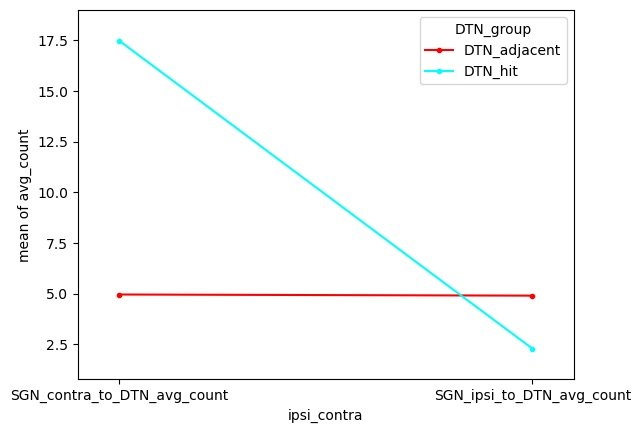

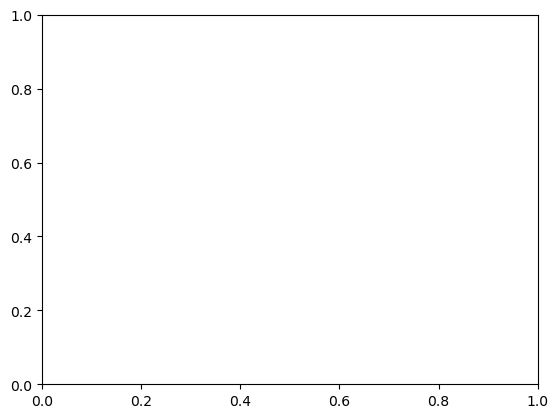

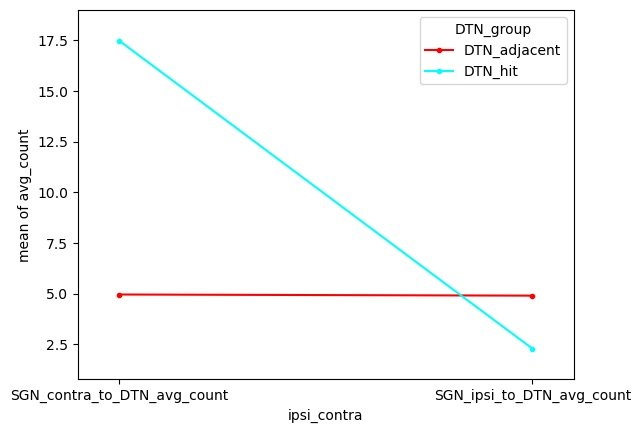

In [8]:
#There's a significant interaction between group(DTN_hit, DTN_adjacent, LMN_hit, LMN_adjacent) and projection area(to_LMN, to_DTN)
#We should just do a t-test ;-)
from statsmodels.graphics.factorplots import interaction_plot
#re-melting - maybe we messed up the indexing by filtering melted df?
df = melted

fig = plt.figure()
ax = fig.add_subplot(111)
interaction_plot(df['ipsi_contra'],df['DTN_group'],df['avg_count'])
#interaction_plot(df['symm_class'],df['brain area'],df['max_slope'],colors=[brain_area_c_dict['NPH'],brain_area_c_dict['PGRNd'],brain_area_c_dict['SGN']])

#plt.savefig('brain_area_by_symm_class_interaction_plot.png')



In [9]:
#still for to_DTN_avg_counts without anterograde DTN brains
#checking to see how normal/homoscedastic our comparisons are....
#get help on interpretation or other ideas
to_DTN_avg_val_df = pd.DataFrame({'group':group_list,'homoscedastic_path':homoscedastic_path_list,
                                 'homoscedastic':homoscedastic_list,'normality_path':normality_path_list,
                                 'normality':normality_list,'dv':dv_list})
to_DTN_avg_val_df[['dv','group','homoscedastic','normality']]
#to_DTN_avg_val_df.to_csv('to_DTN_avg_counts_normality_table_without_anterograde.csv')

,dv,group,homoscedastic,normality
0,avg_count,DTN_group,False,True
1,avg_count,ipsi_contra,True,True


In [10]:
to_DTN_avg_val_df

,group,homoscedastic_path,homoscedastic,normality_path,normality,dv
0,DTN_group,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,False,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,True,avg_count
1,ipsi_contra,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,True,C:\Users\F004b3k\OneDrive\Documents\Taube lab\...,True,avg_count


# SGN_contra-->LMN comparisons (ANOVA) by group (LMN_hit, LMN_adjacent)

In [11]:
#this box is only for LMN_group comparison
#Maybe anova is most approporiate if we're also comparing brain areas (SGN_ipsi vs SGN_contra instead of trying to compare to_LMN and to_DTN in the same comparison )
#Using pg.ANOVA (2 way) for each variable
#using Tukey for posthoc
df = stat_df

#filter out LMN_miss (not enough samples)
df = df.loc[(~(df['LMN_group']=='LMN_miss'))&(~(df['LMN_group'].isnull()==True))]

#get only the SGN_contra_avg_counts going to LMN
#columns we will need....don't add double_label unless we do a double_label comparison
SGN_to_LMN_columns = ['Brain','LMN_group','SGN_contra_to_LMN_avg_count','SGN_ipsi_to_LMN_avg_count']


df = df[SGN_to_LMN_columns]

comparison_ops = ['SGN_contra_to_LMN_avg_count','SGN_ipsi_to_LMN_avg_count']
#pg ANOVA assumptions:
#equal variance

#create a table that stores the comparison, path, homoscedacicity values, normality values

group_list = []
homoscedastic_path_list = []
homoscedastic_list = []
normality_list = []
normality_path_list = []
dv_list = []

#performs an anova and saves the results

#data filters and reasoning if neccessary


#saving location and strings
if os.path.exists(os.path.join(cwd,'to_LMN_avg_counts_stats')) == False:
    stat_folder = os.mkdir('to_LMN_avg_counts_stats')
stat_folder = os.path.abspath(os.path.join(cwd,'to_LMN_avg_counts_stats'))

#need to melt the dataframe so 'counts'is the only variable?
melted = pd.melt(df, id_vars=['Brain','LMN_group'], 
                 value_vars=comparison_ops,
                var_name='ipsi_contra',value_name='avg_count')



#filter such that we only have avg to_LMN numbers for LMN hit and miss and only avg to_LMN numbers for LMN hit and miss
#dependent variable (one for pg.anova)
#melted['group'] = np.where(melted['projection_area'].str.contains('DTN'),melted['DTN_group'],melted['LMN_group'])
#filter out NaNs and LMN_miss or DTN_miss as these are not included in the paper
#melted = melted.loc[(melted['group'].isnull()==False) & (melted['group'].str.contains('LMN_miss')==False) & (melted['group'].str.contains('DTN_miss')==False)]

df = melted
dv = 'avg_count'
#list of variables to compare
between = ['LMN_group','ipsi_contra']
base_savestring = '_'.join(between)
base_savestring = '_'.join([dv,base_savestring])
anova_savestring = 'ANOVA.csv'
#show and save anova table for 'between'
df.anova(dv=dv,between=between).to_csv(os.path.join(stat_folder,
                (base_savestring + anova_savestring)))

for group in between:

    #string for saving
    tukey_savestring = 'tukey.csv'
    #equal_variances
    homoscedasticity_savestring = 'homoscedasticity.csv'
    #normality
    normality_savestring = 'normality.csv' 
    #get and save normality/equal variance data for the comparisons
    homoscedasticity = pg.homoscedasticity(data=df,dv=dv,group=group)
    homoscedasticity.to_csv(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' +homoscedasticity_savestring)))
    normality = pg.normality(data=df,dv=dv,group=group)
    normality.to_csv(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' + normality_savestring)))
    #append normality and homoscedacity true/false and csv location to lists for val_df
    group_list.append(group)
    homoscedastic_path_list.append(os.path.abspath(os.path.join(stat_folder,(base_savestring +'group_' + group + '_' + homoscedasticity_savestring))))
    homoscedastic_list.append(homoscedasticity['equal_var'].values[0])
    normality_list.append(normality['normal'].values[0])
    normality_path_list.append(os.path.abspath(os.path.join(stat_folder,(base_savestring + 'group_' + group + '_' +normality_savestring))))
    dv_list.append(dv)
    #save tukey comparison table
    #between for tukey has to be single group
    tukey = df.pairwise_tukey(dv=dv,between=group)

    tukey.to_csv(os.path.join(stat_folder,'_'.join(['dv',dv,'group',group,tukey_savestring])))




#interpretation:
    #normality/homoscedasticity - 
        #ipsi_contra homoscedasticity = True
        #ipsi_contra normality = True for contra, False for ipsi
        #LMN_group homoscedasticity = True
        #LMN_group normality = True
        
        

#anovas/tukeys
#no sig difference between LMN groups for ipsi vs contra or LMN hit/adjacent.  (p>0.3)



#plotting the interaction below


In [12]:
#still for to_LMN_avg_counts
#checking to see how normal/homoscedastic our comparisons are....
#get help on interpretation or other ideas
to_LMN_avg_val_df = pd.DataFrame({'group':group_list,'homoscedastic_path':homoscedastic_path_list,
                                 'homoscedastic':homoscedastic_list,'normality_path':normality_path_list,
                                 'normality':normality_list,'dv':dv_list})
to_LMN_avg_val_df[['dv','group','homoscedastic','normality']]
#to_DTN_avg_val_df.to_csv('to_DTN_avg_counts_normality_table.csv')

,dv,group,homoscedastic,normality
0,avg_count,LMN_group,True,True
1,avg_count,ipsi_contra,True,True
